In [1]:
%matplotlib widget

from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa

def mat2rpy(R):
    """
    Convert a 3x3 rotation matrix to roll, pitch, and yaw angles in radians.
    """
    # Extract yaw (psi)
    psi = np.arctan2(R[1][0], R[0][0])

    # Extract pitch (theta)
    theta = np.arctan2(-R[2][0], np.sqrt(R[1][0]**2 + R[0][0]**2))

    # Extract roll (phi)
    phi = np.arctan2(R[2][1], R[2][2])

    return (np.rad2deg(phi), np.rad2deg(theta), np.rad2deg(psi))

def euler_to_rotmat(roll, pitch, yaw):
    # Convert angles from degrees to radians
    r = np.deg2rad(roll)
    p = np.deg2rad(pitch)
    y = np.deg2rad(yaw)

    # Calculate trigonometric functions
    sr = np.sin(r)
    cr = np.cos(r)
    sp = np.sin(p)
    cp = np.cos(p)
    sy = np.sin(y)
    cy = np.cos(y)

    # Construct rotation matrix
    R_x = np.array([[1, 0, 0],
                    [0, cr, -sr],
                    [0, sr, cr]])

    R_y = np.array([[cp, 0, sp],
                    [0, 1, 0],
                    [-sp, 0, cp]])

    R_z = np.array([[cy, -sy, 0],
                    [sy, cy, 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x

    return R

def convert_to_0_360(input):
    if input < 0:
        return input + 360
    else:
        return input
    
def convert_to_continuous(input_val, offset):
    output = input_val - offset
    if output > 180:
        output -= 360
    elif output < -180:
        output += 360
    return output

In [10]:
f_name = 'apt2.txt'

#Variables
GYRO_THRESHOLD = 25 #walk
dt = 0.014
acc_noise = 0.1
gyr_noise = 0.01
g = np.array([[0],[0],[9.8]])
r_noise = 0.001
fsize = (9,6)
m_noise = 0.03
b_noise = 20
ekf = 1 #ekf 1: HDR correction; ekf 0: mag and gyro

In [11]:
# data = pd.read_csv(f'C:/Users/workshop/Documents/Masters-NYU/ms_project/test_data/{f_name}', usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], names=['accx','accy','accz','laccx','laccy','laccz','gyrox','gyroy','gyroz','quatx','quaty','quatz','quatw','y','p','r'], header = None, encoding=None)
data = pd.read_csv(f'C:/Users/workshop/Documents/Masters-NYU/ms_project/test_data/{f_name}')
data.head()
m, n = np.shape(data)
print(m,n)

accx = data["accx"].to_numpy()
accy = data["accy"].to_numpy()
accz = data["accz"].to_numpy()
gyrox = data["gyrox"].to_numpy()
gyroy = data["gyroy"].to_numpy()
gyroz = data["gyroz"].to_numpy()
magx = data["magx"].to_numpy()
magy = data["magy"].to_numpy()
magz = data["magz"].to_numpy()
roll = data["roll"].to_numpy()
pitch = data["pitch"].to_numpy()
yaw = data["yaw"].to_numpy()

t = np.arange(0,m)
t = t *0.01
t=(t.reshape(-1,1))
t = np.asarray(t)
t=(t.reshape(-1,1))


3064 12


Text(0, 0.5, 'Stationary Flag')

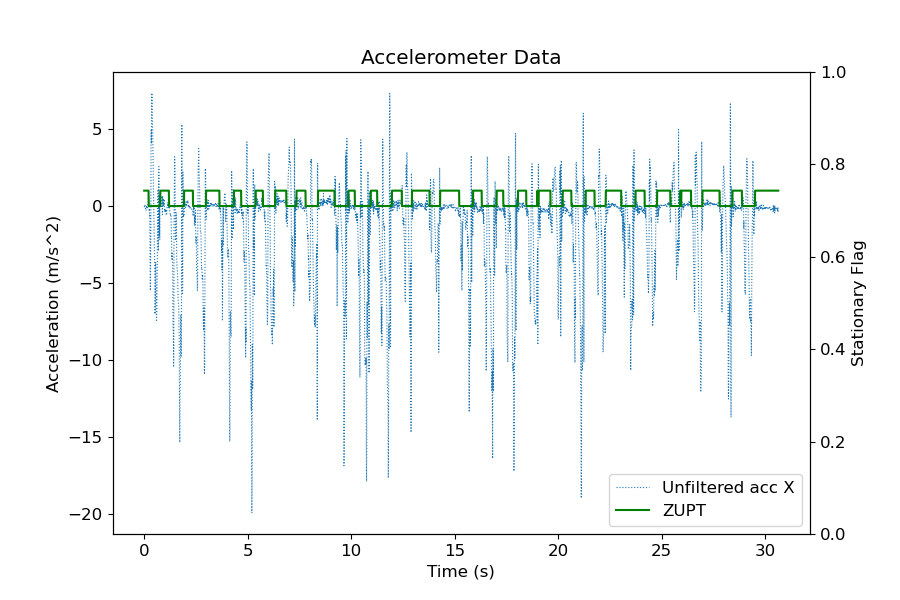

In [12]:
# Variables
flag = np.zeros(m)

for i in range(m):
  # Read gyro and accelerometer values
  window = 5
  gyro_value = np.sqrt(gyrox[i]**2 + gyroy[i]**2 + gyroz[i]**2)

  if i>window:
    gyro_sum = 0   
    for w in range(window):
      gyro_value = np.sqrt(gyrox[i-w]**2 + gyroy[i-w]**2 + gyroz[i-w]**2)
      gyro_sum += gyro_value

    gyro_value = gyro_sum/window

  if (gyro_value) < GYRO_THRESHOLD:
    flag[i] = 1


plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 12})

plt.plot(t,accx-accx[0], linestyle = ':', linewidth = 0.8,  label = 'Unfiltered acc X')
plt.plot(t,flag, linestyle = 'solid', linewidth = 1.5,  label = 'ZUPT', color = 'green')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Accelerometer Data')
plt.legend()
plt.twinx()
plt.ylabel('Stationary Flag')

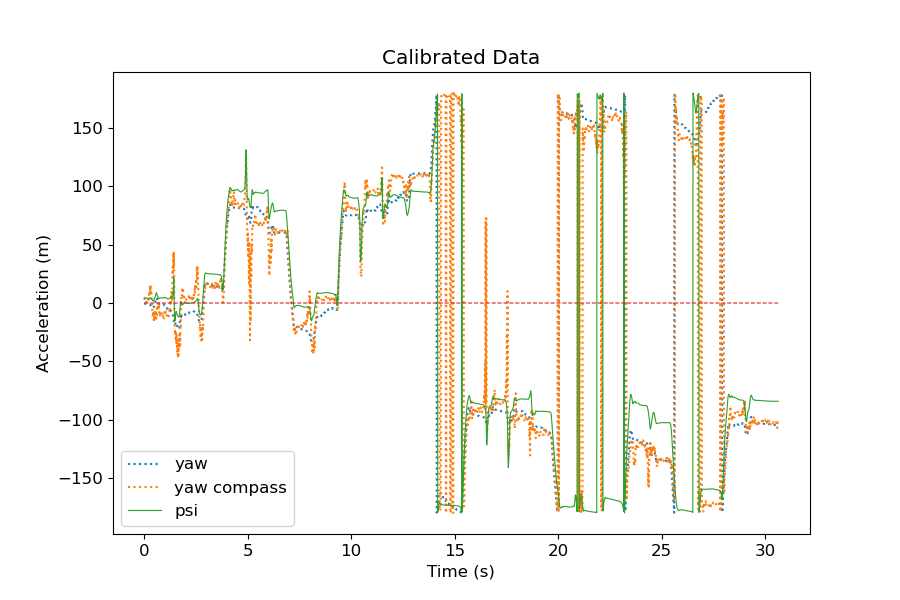

In [13]:
pos = np.zeros((m,3))
vel = np.zeros((m,3))
mag_n = np.zeros((m,3))
yaw_compass = np.zeros(m)

theta = -np.rad2deg(np.arcsin(accx[0]/9.8))
phi   =  np.rad2deg(np.arctan2(accy[0]/9.8,accz[0]/9.8))
mag_n[0] = (euler_to_rotmat(phi,theta,0) @ np.array([[magx[0]],[magy[0]], [magz[0]]])).T
yaw_compass[0] = convert_to_continuous(np.rad2deg(-np.arctan2(mag_n[0,1],mag_n[0,0]))+90,180)
psi   =  yaw_compass[0]
# psi   =  yaw[0]
# psi   =  0

psi_prev  = psi
psi_prev2 = psi

C_prev = euler_to_rotmat(phi,theta,psi)

errors = np.zeros((m,9))
acc_prev = np.zeros((3,1))
acc_prev[2] = 9.8

if ekf:
    P_prev = np.zeros((9,9))
else:
    P_prev = np.zeros((12,12))

if ekf:
    # print("yaw corr")
    H = np.array([0,0,1, 0,0,0, 0,0,0])
    H = np.vstack((H,np.block([np.zeros((3,3)), np.zeros((3,3)), np.eye(3)])))
    R = np.diag([0.05**2,r_noise**2,r_noise**2,r_noise**2])
else:
    H = np.array([0,0,1, 0,0,0, 0,0,0, 0,0,0])
    H = np.vstack((H,np.block([np.zeros((3,3)),       np.eye(3), np.zeros((3,3)), np.zeros((3,3))])))
    H = np.vstack((H,np.block([np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)),       np.eye(3)])))
    R = np.diag([m_noise,b_noise,b_noise,b_noise, r_noise**2,r_noise**2,r_noise**2])

r = np.zeros(m)
p = np.zeros(m)
y = np.zeros(m)
accx_n = np.zeros(m)

r[0] = phi
p[0] = theta
y[0] = psi

step =0
count = 0
g_sum = np.zeros(3)
gyro_bias = np.zeros(3)
y_avg = 0
init = 0
for i in range(1,m):

    gy = np.deg2rad(gyroy[i]) 
    gx = np.deg2rad(gyrox[i]) 
    gz = np.deg2rad(gyroz[i]) 
    # Strapdown INS system
    ang_rate = np.array([[0, -gz, gy],
                         [gz, 0, -gx],
                         [-gy, gx, 0]])
    
    update_fac = (2*np.eye(3) + ang_rate*dt) @ np.linalg.inv(2*np.eye(3) - ang_rate*dt)
    C = C_prev @ update_fac
    # (r[i],p[i],y[i]) = mat2rpy((C+C_prev)*0.5)
    acc_b = np.array([[accx[i]],
                      [accy[i]],
                      [accz[i]]])

    acc_n = (0.5*(C+C_prev) @ acc_b)
    accx_n[i] = acc_n[0]
    vel[i] = vel[i-1] + (acc_n + acc_prev -2*g).T * dt * 0.5
    pos[i] = pos[i-1] + (vel[i]+vel[i-1]) * dt * 0.5

    S = np.array([[0, -acc_n[2,0], acc_n[1,0]],
                  [acc_n[2,0], 0, -acc_n[0,0]],
                  [-acc_n[1,0], acc_n[0,0], 0]])
                  
    if ekf:
        F = np.block([[np.eye(3), np.zeros((3,3)), np.zeros((3,3))],
                      [np.zeros((3,3)), np.eye(3), np.eye(3)*dt],
                      [-S*dt, np.zeros((3,3)), np.eye(3)]])

        Q = (np.diag([gyr_noise, gyr_noise, gyr_noise, 0, 0, 0, acc_noise, acc_noise, acc_noise])*dt) **2
    else:
        F = np.block([[      np.eye(3),       -C_prev*dt, np.zeros((3,3)), np.zeros((3,3))],
                      [np.zeros((3,3)),       np.eye(3), np.zeros((3,3)), np.zeros((3,3))],
                      [np.zeros((3,3)), np.zeros((3,3)),       np.eye(3),    np.eye(3)*dt],
                      [          -S*dt, np.zeros((3,3)), np.zeros((3,3)),       np.eye(3)]])

        Q = (np.diag([gyr_noise*1e0, gyr_noise*1e0, gyr_noise*1e0, gyr_noise, gyr_noise, gyr_noise, 0, 0, 0, acc_noise, acc_noise, acc_noise])*dt) **2
    
    P = F @ P_prev @ F.T + Q

    
    # C = euler_to_rotmat(r[i],p[i],yaw[i])
    
    if flag[i]:
        count+=1
        if count == 10:
            init = 1
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        # print("K",K)
        (r[i],p[i],y[i]) = mat2rpy(C)
        
        y_avg += (y[i])
        # print(y[i])

        if ekf:
            diff = (y[i]) - ((psi_prev + psi_prev2)*0.5)
            # print('diff',diff, y[i], ((psi_prev + psi_prev2)*0.5))
            if abs(diff)>10:
                diff = 0 
            # print("new diff", diff)
        else:
            mag_n[i] = (euler_to_rotmat(r[i],p[i],0) @ np.array([[magx[i]],[magy[i]], [magz[i]]])).T
            yaw_compass[i] = convert_to_continuous(np.rad2deg(-np.arctan2(mag_n[i,1],mag_n[i,0]))+90,180)
            diff = convert_to_0_360(y[i])-convert_to_0_360(yaw_compass[i])
        
        x = np.hstack((np.deg2rad(diff), vel[i]))

        if ekf:
            error = K@x
            P = (np.eye(9) - K @ H) @ P
        else:
            meas = np.hstack((diff,np.array([0,0,0])))
            meas = np.hstack((meas,vel[i]))
            error = K@meas.T
            P = (np.eye(12) - K @ H) @ P
        # print(diff , error[2])
        
        ang_rate_correction = np.array([[0, error[2], -error[1]],
                                        [-error[2], 0, error[0]],
                                        [error[1], -error[0], 0]])

        correction_factor = (2*np.eye(3) + ang_rate_correction) @ np.linalg.inv(2*np.eye(3) - ang_rate_correction)
        C = correction_factor@C        

        if ekf:
            pos[i] = pos[i] - error[3:6]
            vel[i] = vel[i] - error[6:9]
        else:
            pos[i] = pos[i] - error[6:9]
            vel[i] = vel[i] - error[9:12]
    else:
        if init:
            step +=1
            y_avg = y_avg/count
            # print(step, y_avg, psi_prev, psi_prev2)
            psi_prev2 = psi_prev
            psi_prev = y_avg
            init = 0
            y_avg = 0
            
        count = 0
        
   
    
    # End game
    (r[i],p[i],y[i]) = mat2rpy(C)
    mag_n[i] = (euler_to_rotmat(r[i],p[i],0) @ np.array([[magx[i]],[magy[i]], [magz[i]]])).T
    yaw_compass[i] = convert_to_continuous(np.rad2deg(-np.arctan2(mag_n[i,1],mag_n[i,0]))+90,180)
    acc_prev = acc_n
    C_prev = C
    P_prev = P

plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 12})
# plt.plot(t,roll, linestyle = ':', linewidth = 1.5,  label = 'roll')
# plt.plot(t,pitch, linestyle = ':', linewidth = 1.5,  label = 'pitch')
plt.plot(t,yaw, linestyle = ':', linewidth = 1.5,  label = 'yaw')
plt.plot(t,yaw_compass, linestyle = ':', linewidth = 1.5,  label = 'yaw compass')
# plt.plot(t,r, linestyle = 'solid', linewidth = 0.8,  label = 'phi')
# plt.plot(t,p, linestyle = 'solid', linewidth = 0.8,  label = 'theta')
plt.plot(t,y, linestyle = 'solid', linewidth = 0.8,  label = 'psi')


plt.plot(t,np.zeros(m), linestyle = '--', linewidth = 0.8)


plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m)')
plt.title('Calibrated Data')
# plt.ylim(-90, 90)
plt.legend()

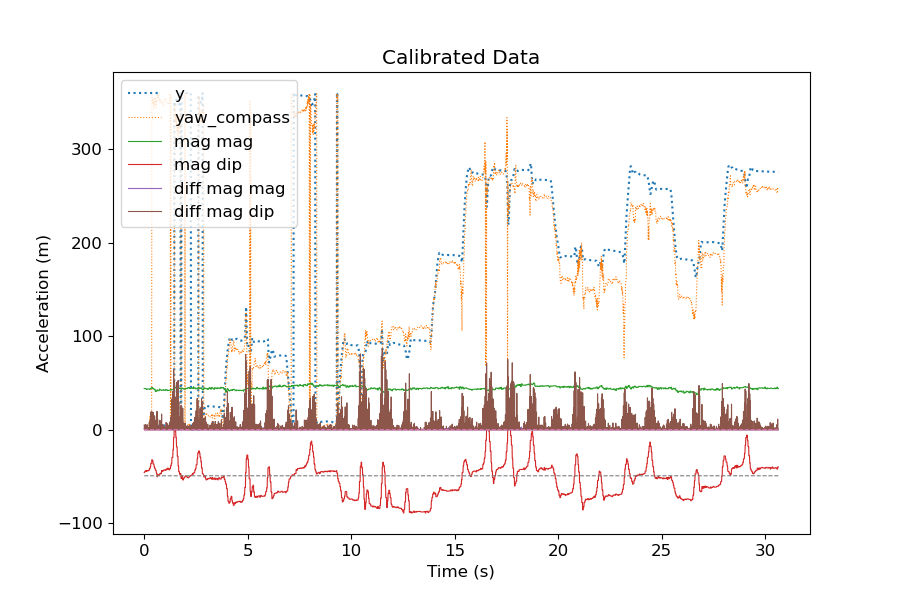

In [14]:
magt = np.zeros(m)
dip = np.zeros(m)
dip_flag = np.zeros(m)
mag_flag = np.zeros(m)
for i in range(m):
    y[i] = convert_to_0_360(y[i])
    yaw_compass[i] = convert_to_0_360(yaw_compass[i])
    yaw[i] = convert_to_0_360(yaw[i])
    magt[i] = np.linalg.norm(np.array([magx[i],magy[i],magz[i]]))
    dip[i] = np.rad2deg(np.arctan2(magz[i],np.sqrt(magx[i]**2 + magy[i]**2)))

dip_avg = np.average(dip[0:500])

dmagt = np.diff(magt)
ddip = np.diff(dip)
dmagt = np.insert(dmagt,0,-1)
ddip = np.insert(ddip,0,-1)
for i in range(m):
    if abs(ddip[i]) > 10:
        dip_flag[i] = 100
    if abs(dmagt[i]) > 2:
        mag_flag[i] = 100
plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 12})
plt.plot(t,y, linestyle = ':', linewidth = 1.5,  label = 'y')
# plt.plot(t,yaw, linestyle = ':', linewidth = 1.5,  label = 'yaw')
plt.plot(t,yaw_compass, linestyle = ':', linewidth = .8,  label = 'yaw_compass')
plt.plot(t,magt, linestyle = 'solid', linewidth = .8,  label = 'mag mag')
plt.plot(t,dip, linestyle = 'solid', linewidth = .8,  label = 'mag dip')
plt.plot(t,abs(dmagt), linestyle = 'solid', linewidth = .8,  label = 'diff mag mag')
plt.plot(t,abs(ddip)*5, linestyle = 'solid', linewidth = .8,  label = 'diff mag dip')
# plt.plot(t,dip_flag, linestyle = 'solid', linewidth = .8,  label = 'dip flag')
# plt.plot(t,mag_flag, linestyle = 'solid', linewidth = .8,  label = 'mag flag')
plt.plot(t,np.zeros(m), linestyle = '--', linewidth = 0.8)
plt.plot(t,np.ones(m)*dip_avg, linestyle = '--', linewidth = 0.8)


plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m)')
plt.title('Calibrated Data')
# plt.ylim(-90, 90)
plt.legend()

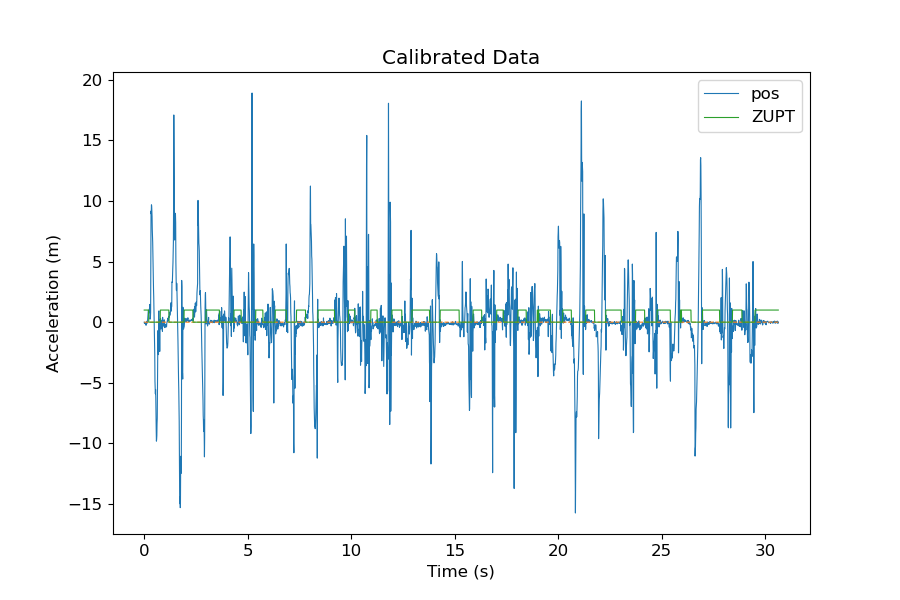

In [15]:
plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 12})
plt.plot(t,accx_n, linestyle = 'solid', linewidth = 0.8,  label = 'pos')
# plt.plot(t,accx, linestyle = 'solid', linewidth = 0.8,  label = 'vel')
plt.plot(t,np.zeros(m), linestyle = '--', linewidth = 0.8)
# plt.plot(t,gyrox*0.1, linestyle = 'solid', linewidth = 0.8,  label = 'error')
plt.plot(t, flag, linestyle = 'solid', linewidth = 0.8,  label = 'ZUPT')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m)')
plt.title('Calibrated Data')
plt.axis()
plt.legend()

Text(0, 0.5, 'Position (m)')

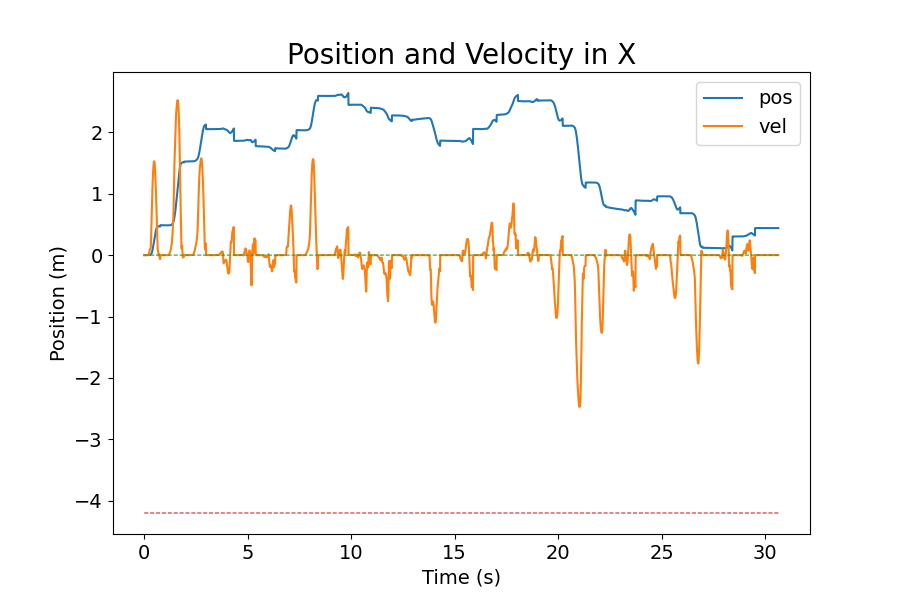

In [16]:
plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 14})
plt.plot(t,pos[:,0], linestyle = 'solid',  label = 'pos')
plt.plot(t,vel[:,0], linestyle = 'solid',  label = 'vel')
plt.plot(t, np.zeros(m), linestyle = '--', linewidth = 0.8)
plt.plot(t,-4.2*np.ones(m), linestyle = '--', linewidth = 0.8)


ex = round(pos[-1,0] + 0,3)
ey = round(pos[-1,1] + 0,3)
# str = 'error: ' + e
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Position and Velocity in X', fontsize =20 )
# plt.axis('equal')

plt.text(4., 8.26,'error x: ' + str(ex) + 'm')
plt.text(4., 7.26,'error y: ' + str(ey) + 'm')
# plt.ylim(-6,10)
plt.legend()
# plt.twinx()
# plt.ylim(-2.6,6.3)
plt.ylabel('Position (m)')

Text(0.5, 1.0, 'Position in XY')

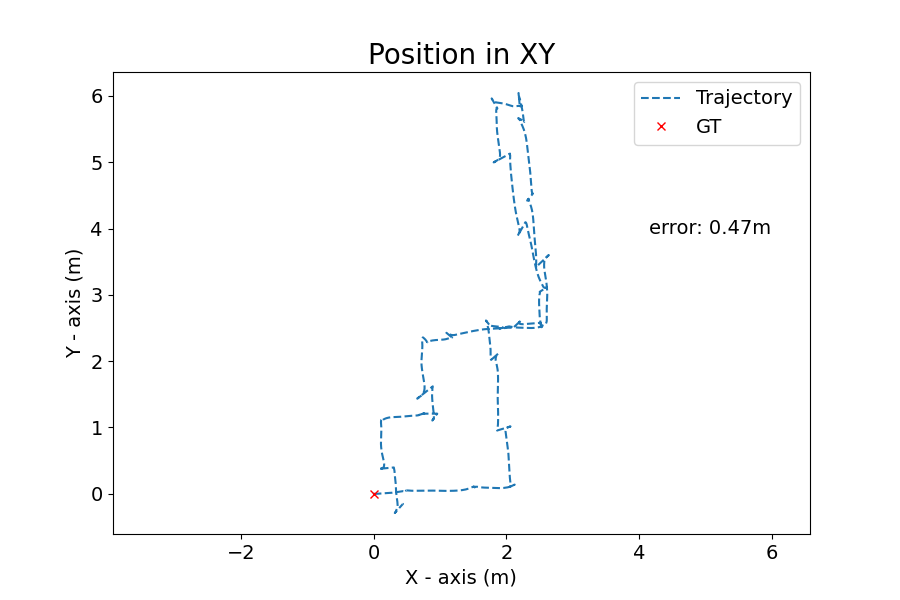

In [17]:
err = np.linalg.norm(np.array([pos[-1,0], pos[-1,1]]))
plt.figure(figsize = fsize)
plt.rcParams.update({'font.size': 14})
plt.plot(pos[:,0],pos[:,1], linestyle = '--',  label = 'Trajectory')
plt.plot(0.,0,'x', color = 'red', label = 'GT')
plt.annotate('error: {:.2f}m'.format(err), xy=(4, 4), xytext=(10, 10), 
             textcoords='offset pixels', ha='left', va='top')
plt.xlabel('X - axis (m)')
plt.ylabel('Y - axis (m)')
plt.title('XY')
plt.axis('equal')
# plt.ylim(-0.25,0.25)
plt.legend()

plt.title('Position in XY', fontsize =20 )
